# Benchmark Training

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from summit import *
from multitask import *

import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2
from ord_schema.proto.reaction_pb2 import *
from ord_schema.message_helpers import find_submessages, get_reaction_smiles
from ord_schema import units

from rdkit import Chem
import rdkit.Chem.rdChemReactions as react
from pint import UnitRegistry

from pathlib import Path
from typing import Iterable
import pandas as pd

In [3]:
ureg = UnitRegistry()

## Load datasets

### Baumgartner 

In [149]:
data_path = Path("../data")
baumgartner_suzuki_path = data_path / "baumgartner_suzuki" / "ord"

In [150]:
# Load dataset message
baumgartner_dataset = message_helpers.load_message(
        str(baumgartner_suzuki_path/ f"baumgartner_suzuki.pb"), 
        dataset_pb2.Dataset
    )

In [151]:
# Ensure dataset validates
valid_output = validations.validate_message(baumgartner_dataset)
valid_output.warnings

['Dataset.reactions[0].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, not fractions (9.999999747378752e-05 used)',
 'Dataset.reactions[1].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, not fractions (9.999999747378752e-05 used)',
 'Dataset.reactions[2].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, not fractions (9.999999747378752e-05 used)',
 'Dataset.reactions[3].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, not fractions (9.999999747378752e-05 used)',
 'Dataset.reactions[4].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, not fractions (9.999999747378752e-05 used)',
 'Dataset.reactions[5].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, not fractions (9.999999747378752e-05 used)',
 'Dataset.reactions[6].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, no

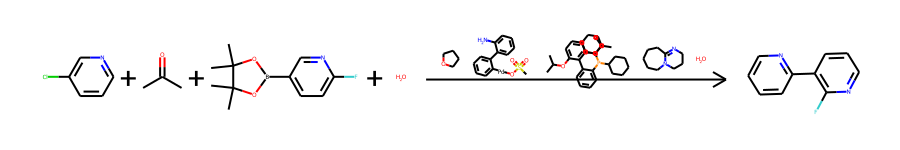

In [152]:
# Example reaction for visualization
rxn_smiles = message_helpers.get_reaction_smiles(
    baumgartner_dataset.reactions[0], 
    generate_if_missing=True
)
react.ReactionFromSmarts(rxn_smiles, useSmiles=True)

In [153]:
# Convert datasets to pandas dataframe
df = suzuki_reaction_to_dataframe(
    baumgartner_dataset.reactions, 
)


In [155]:
df["ligand_smiles"].unique()

array(['CC(C)Oc1cccc(OC(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1',
       'COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1',
       'c1ccc(P(c2ccccc2)c2ccccc2)cc1', 'CC(C)(C)P(C(C)(C)C)C(C)(C)C',
       'CC1(C)c2cccc(P(c3ccccc3)c3ccccc3)c2Oc2c(P(c3ccccc3)c3ccccc3)cccc21',
       'C1CCC(P(C2CCCCC2)C2CCCCC2)CC1',
       'CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1'],
      dtype=object)

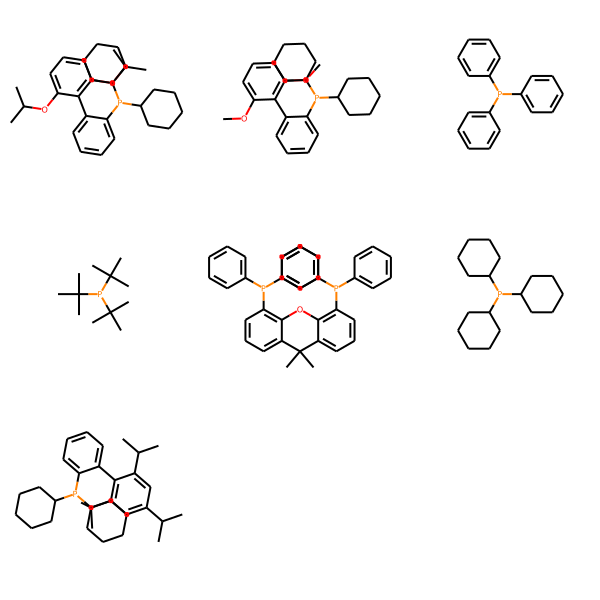

In [154]:
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in df["ligand_smiles"].unique()]
    
)

Table Columns:
- [x] Electrophile / Nucleophile SMILES
- [x] Reactant concentrations or equivalents
- [x] Pre-catalyst
- [x] Ligand
- [x] Temperature
- [x] Reaction Time
- [x] Yield

In [10]:
# Remove units from column names
no_units = lambda s: s.split(" ")[0]
dfs = [df.rename(columns=no_units) for df in dfs]

In [22]:
continuous = [v.name for v in domain.input_variables if v.variable_type=="continuous"]
for df in dfs:
    for c in continuous:
        df[c] = df[c].astype(float)

### Perera 

In [156]:
data_path = Path("../data")
perera_suzuki_path = data_path / "perera_suzuki"

In [157]:
# Perera
perera_dataset = message_helpers.load_message(
    str(perera_suzuki_path/ f"perera.pb"), 
    dataset_pb2.Dataset
)

In [158]:
# Print out the first reaction
inputs =  perera_dataset.reactions[0].inputs
print(inputs["Ligand in Solvent"])

components {
  identifiers {
    type: SMILES
    value: "CC(C)(C)P(C(C)(C)C)C(C)(C)C"
  }
  amount {
    moles {
      value: 0.05000000074505806
      units: MICROMOLE
    }
  }
  reaction_role: CATALYST
}
components {
  identifiers {
    type: SMILES
    value: "Cc1ccccc1"
  }
  amount {
    volume {
      value: 1.0
      units: MICROLITER
    }
    volume_includes_solutes: true
  }
  reaction_role: SOLVENT
}
addition_order: 1



In [133]:
catalysts = []
reactants = []
for reaction in perera_dataset.reactions:
    inputs = reaction.inputs
    for inp in inputs:
        components = inputs[inp].components
        for c in components:
            if c is not None:
                if c.reaction_role == ReactionRole.REACTANT:
                    reactants.extend([
                         id_.value for id_ in c.identifiers 
                         if id_.type == CompoundIdentifier.SMILES
                    ])
                    count
                if c.reaction_role == ReactionRole.CATALYST:
                    for id_ in c.identifiers:
                        if id_.type == CompoundIdentifier.SMILES:
                            if "CC(=O)[O-].CC(=O)[O-].[Pd+2]" in id_.value:
                                 id_.value = "CC(=O)O[Pd]OC(=O)C"
                            catalysts.append(id_.value)

In [145]:
inputs = perera_dataset.reactions[0].inputs
count = 0
reactants = []
for inp in inputs:
    components = inputs[inp].components
    for c in components:
        if c is not None:
            if c.reaction_role == ReactionRole.REACTANT:
                reactants.extend([
                     id_.value for id_ in c.identifiers 
                     if id_.type == CompoundIdentifier.SMILES
                ])
                count += 1
print(count)

2


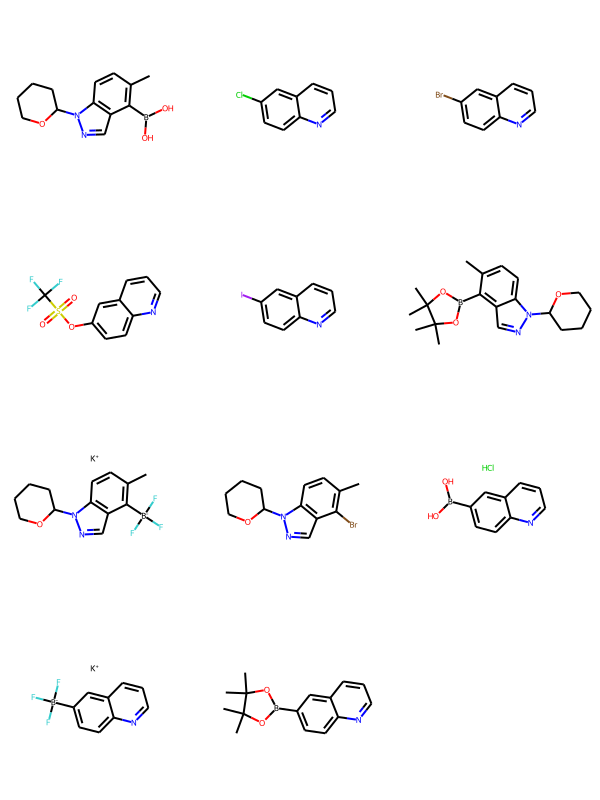

In [134]:
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in pd.unique(reactants)]
)

In [135]:
splits = [split_cat_ligand(cat) for cat in pd.unique(catalysts)]
pre_cats = [Chem.CanonSmiles(pre_cat) for pre_cat,_  in splits]
ligands = [Chem.CanonSmiles(ligand) for _, ligand in splits if ligand != ""]

In [136]:
count = 0
for smiles in ligands:
    if smiles in df["ligand_smiles"].unique():
        count += 1
print(f"Matching ligands to Baumgartner: {count} of {len(ligands)}")

Matching ligands to Baumgartner: 6 of 11


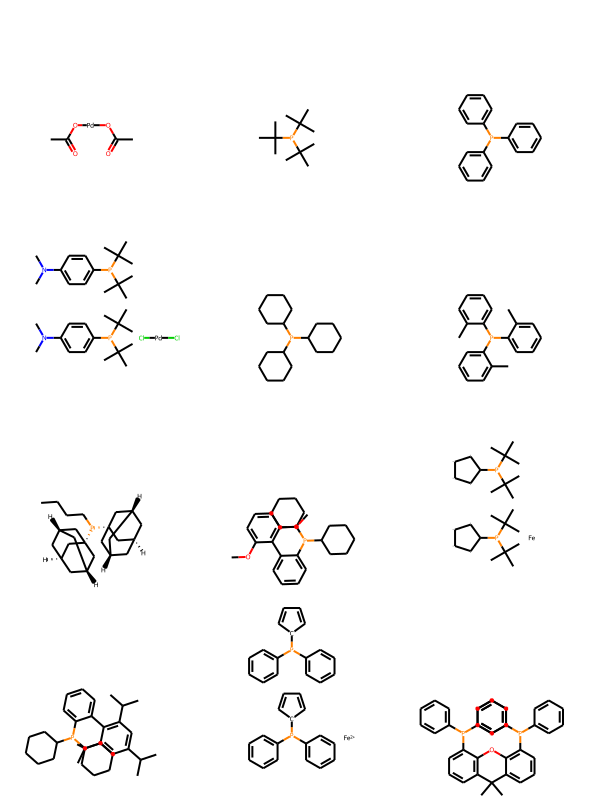

In [137]:
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in  pd.unique(catalysts)]
)

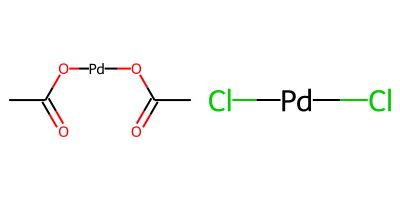

In [138]:
Chem.Draw.MolsToImage(
    [Chem.MolFromSmiles(smiles) for smiles in pre_cats if smiles is not ""]
)

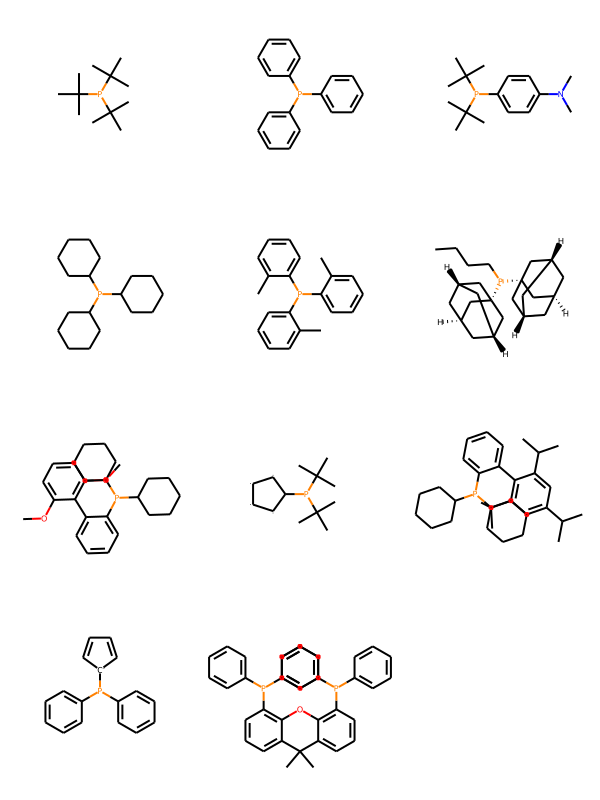

In [139]:
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in ligands]
)

In [140]:
ligands

['CC(C)(C)P(C(C)(C)C)C(C)(C)C',
 'c1ccc(P(c2ccccc2)c2ccccc2)cc1',
 'CN(C)c1ccc(P(C(C)(C)C)C(C)(C)C)cc1',
 'C1CCC(P(C2CCCCC2)C2CCCCC2)CC1',
 'Cc1ccccc1P(c1ccccc1C)c1ccccc1C',
 'CCCCP([C@]12C[C@H]3C[C@H](C[C@H](C3)C1)C2)[C@]12C[C@H]3C[C@H](C[C@H](C3)C1)C2',
 'COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1',
 'CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C',
 'CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1',
 'c1ccc(P(c2ccccc2)[c-]2cccc2)cc1',
 'CC1(C)c2cccc(P(c3ccccc3)c3ccccc3)c2Oc2c(P(c3ccccc3)c3ccccc3)cccc21']

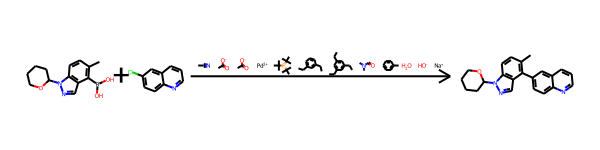

In [10]:
smiles = get_reaction_smiles(
    perera_dataset.reactions[0], generate_if_missing=True
)
react.ReactionFromSmarts(smiles, useSmiles=True)

## Domain

In [60]:
domain = Domain()

# Decision variables
domain += ContinuousVariable(
    name="electrophile_concentration",
    description="Concentration of electrophile in molar",
    bounds=[0,2]
)
domain += ContinuousVariable(
    name="nucleophile_concentration",
    description="Concentration of nucleophile in molar",
    bounds=[0,2]
)

domain += CategoricalVariable(
    name="pre_catalyst_smiles",
    description="SMILES of the pre-catalyst",
    levels=dfs[0]["pre_catalyst_smiles"].unique().tolist()
)

domain += ContinuousVariable(
    name="catalyst_concentration",
    description="Concentration of pre_catalyst in molar",
    bounds=[0,2]
)

domain += CategoricalVariable(
    name="ligand_smiles",
    description="SMILES of the ligand",
    levels=dfs[0]["ligand_smiles"].unique().tolist()
)
domain += ContinuousVariable(
    name="ligand_ratio",
    description="Ratio of pre-catalyst to ligand",
    bounds=[0,5]
)

# Objectives
domain += ContinuousVariable(
    name="yld",
    description="Reaction yield",
    bounds=[0,100],
    is_objective=True
)
domain

Name,Type,Description,Values
electrophile_concentration,"continuous, input",Concentration of electrophile in molar,"[0,2]"
nucleophile_concentration,"continuous, input",Concentration of nucleophile in molar,"[0,2]"
pre_catalyst_smiles,"categorical, input",SMILES of the pre-catalyst,2 levels
catalyst_concentration,"continuous, input",Concentration of pre_catalyst in molar,"[0,2]"
ligand_smiles,"categorical, input",SMILES of the ligand,7 levels
ligand_ratio,"continuous, input",Ratio of pre-catalyst to ligand,"[0,5]"
yld,"continuous, maximize objective",Reaction yield,"[0,100]"


## Train Benchmarking

In [28]:
dfs[0]["electrophile_concentration"].describe()

count    95.000000
mean      0.088537
std       0.028030
min       0.076462
25%       0.076463
50%       0.076464
75%       0.076466
max       0.152933
Name: electrophile_concentration, dtype: float64

In [61]:
dfs[0][[v.name for v in domain.input_variables if v.variable_type=="continuous"]].describe()

,electrophile_concentration,nucleophile_concentration,catalyst_concentration,ligand_ratio
count,95.000000,95.000000,95.000000,95.0
mean,0.088537,0.133771,0.001623,1.0
std,0.028030,0.042342,0.000828,0.0
min,0.076462,0.115517,0.000384,1.0
25%,0.076463,0.115518,0.000867,1.0
50%,0.076464,0.115520,0.001912,1.0
75%,0.076466,0.115522,0.001922,1.0
max,0.152933,0.231047,0.003857,1.0


In [ ]:
emul = ExperimentalEmulator("baumgartner_suzuki", domain=domain, dataset=dfs[0])
emul.train(cv_folds=5, max_epochs=1000, verbose=1)

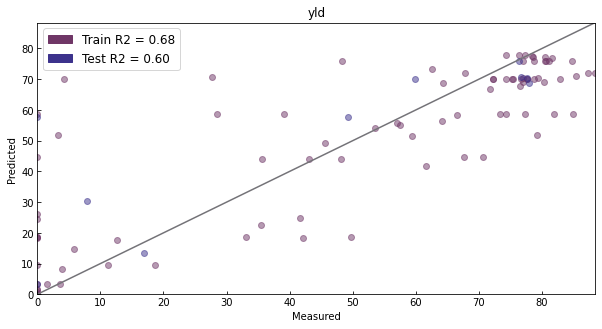

In [65]:
fig, ax = emul.parity_plot(include_test=True)